In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
import statsmodels.api as sm

read in data

In [2]:
train=pd.read_csv("./train.csv")
test=pd.read_csv("./test.csv")

*handle* nulls and outliers

In [3]:

train = train.drop(train[train['BsmtFin SF 1']>5000].index)
train = train.drop(train[train['Total Bsmt SF']>6000].index)
train = train.drop(train[train['1st Flr SF']>4000].index)


In [4]:
def drop_col(data,col):
    return data.drop(columns=col, axis =1, inplace=True)

In [5]:
drop_col(train,['Unnamed: 0','PID','Id'])
drop_col(test,['PID','Id']) #these seem like they will have little impact

sorting ohe columns, will make handling nulls easier

In [6]:
#columns to ohe
ohe_cols=[col for col in train.columns if train[col].dtype == "object"]
ohe_cols=ohe_cols+['Mo Sold','MS SubClass']

In [ ]:
non_ohe_cols=[col for col in train.columns if col not in ohe_cols]
non_ohe_cols # lets check through here again for any ordinals

Ill use "none" for all null categorical values, it will make it easier, and represent its own column when ohe, since each column the absence might be something different

In [ ]:
for col in ohe_cols:
    train[col].fillna('none', inplace=True)
    test[col].fillna('none', inplace=True)

train[ohe_cols].isnull().sum() #looks like we got them all

In [ ]:
need_vals_train=[col for col in non_ohe_cols if train[col].isnull().sum()>0]
need_vals_test=[col for col in non_ohe_cols if train[col].isnull().sum()>0]

train[need_vals_train].isnull().sum(),test[need_vals_test].isnull().sum()

In [11]:
train['Lot Frontage'].fillna(62, inplace=True)
test['Lot Frontage'].fillna(62, inplace=True)

In [13]:
train[train['Garage Yr Blt'].isnull()][['Garage Cars', 'Garage Area','Garage Yr Blt','Year Built','Year Remod/Add']]

,Garage Cars,Garage Area,Garage Yr Blt,Year Built,Year Remod/Add
25,0.0,0.0,NaN,2007,2008
32,0.0,0.0,NaN,1919,1950
39,0.0,0.0,NaN,1916,1995
50,0.0,0.0,NaN,1915,1950
62,0.0,0.0,NaN,1961,1961
...,...,...,...,...,...
1483,0.0,0.0,NaN,1930,1950
1488,0.0,0.0,NaN,1910,1950
1497,0.0,0.0,NaN,1970,1970
1501,0.0,0.0,NaN,1987,1988


In [14]:
train[train['Bsmt Half Bath'].isnull()][['BsmtFin SF 1','BsmtFin SF 2', 'Bsmt Unf SF']]

,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF
908,0.0,0.0,0.0
1195,NaN,NaN,NaN


In [16]:
train[['Mas Vnr Type', 'Mas Vnr Area','Total Bsmt SF', '1st Flr SF', '2nd Flr SF',]].describe()

,Mas Vnr Area,Total Bsmt SF,1st Flr SF,2nd Flr SF
count,1518.000000,1536.000000,1536.000000,1536.000000
mean,98.148221,1051.313151,1157.025391,329.626302
std,173.298816,424.677130,381.477368,425.763582
min,0.000000,0.000000,334.000000,0.000000
25%,0.000000,793.000000,874.000000,0.000000
50%,0.000000,992.000000,1092.000000,0.000000
75%,160.000000,1310.250000,1392.000000,689.250000
max,1600.000000,3206.000000,3820.000000,1862.000000


In [17]:
train['Garage Yr Blt'].fillna(1950, inplace=True)
test['Garage Yr Blt'].fillna(1950, inplace=True)
train['Mas Vnr Area'].fillna(0, inplace=True)
test['Mas Vnr Area'].fillna(0, inplace=True)

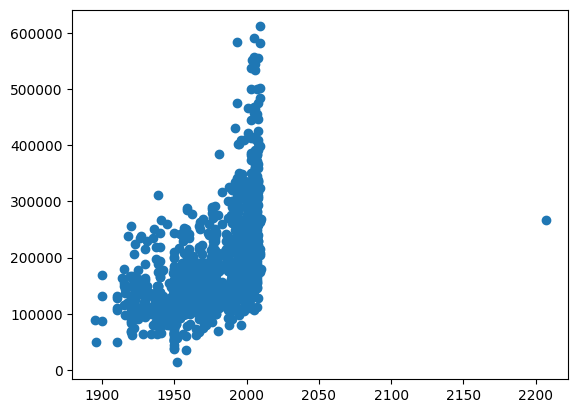

In [18]:
plt.scatter(train['Garage Yr Blt'], train['SalePrice'])



all clean time to ohe


In [21]:
ohe=OneHotEncoder(sparse_output = False).set_output(transform='pandas')
transformed=ohe.fit_transform( train[ohe_cols])
transformed_test=ohe.fit_transform( test[ohe_cols])

In [22]:
test_non_ohe_cols=[col for col in non_ohe_cols if col != "SalePrice"]


In [23]:
train_ohe = pd.merge(train[non_ohe_cols], transformed, left_index=True, right_index=True)
test_ohe = pd.merge(test[test_non_ohe_cols], transformed_test, left_index=True, right_index=True)

train_ohe.shape


(1536, 323)

In [24]:
to_drop=test_ohe.columns.difference(train_ohe.columns)
to_drop2=train_ohe.columns.difference(test_ohe.columns)
to_drop,to_drop2 #maybe we can rescue these later


(Index(['Condition 2_RRAe', 'MS Zoning_I (all)', 'Pool QC_Ex',
        'Utilities_NoSeWa', 'Utilities_NoSewr'],
       dtype='object'),
 Index(['Bsmt Cond_Po', 'Bsmt Qual_Po', 'Condition 1_RRNe', 'Condition 1_RRNn',
        'Condition 2_PosA', 'Condition 2_RRAn', 'Condition 2_RRNn',
        'Electrical_FuseP', 'Electrical_Mix', 'Exter Cond_Po',
        'Exterior 1st_AsphShn', 'Exterior 1st_CBlock', 'Exterior 1st_ImStucc',
        'Exterior 1st_Stone', 'Exterior 2nd_CBlock', 'Foundation_Stone',
        'Functional_Sal', 'Garage Cond_Ex', 'Garage Cond_Po', 'Garage Qual_Ex',
        'Garage Qual_Po', 'Heating QC_Po', 'Heating_OthW', 'MS SubClass_150',
        'MS Zoning_A (agr)', 'Misc Feature_Othr', 'Misc Feature_TenC',
        'Neighborhood_GrnHill', 'Neighborhood_Landmrk', 'Pool QC_Fa',
        'Pool QC_TA', 'Roof Matl_Membran', 'Roof Matl_WdShake', 'SalePrice'],
       dtype='object'))

In [25]:
y=train['SalePrice']

this will drop our sale price too


In [ ]:
for col in to_drop: #try ignore unknown categories instead
    try:
        drop_col(test_ohe,col)
        print("dropped")
    except:
        print("its fine", col)
    try:
        drop_col(train_ohe,col)
        print("dropped")
    except:
        print("its fine", col)
for col in to_drop2:
    try:
        drop_col(test_ohe,col)
        print("dropped")
    except:
        print("its fine", col)
    try:
        drop_col(train_ohe,col)
        print("dropped")
    except:
        print("its fine", col)

In [27]:
X=train_ohe.copy()


some feature engineering

In [29]:
# X['Has Pool'] = X['Pool Area'].apply(lambda x: 1 if x > 0 else 0)
# test_ohe['Has Pool'] = test_ohe['Pool Area'].apply(lambda x: 1 if x > 0 else 0)

# X['Has Fireplace'] = X['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
# test_ohe['Has Fireplace'] = test_ohe['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
#these would be redundant

X['Has Bsmt'] = X['Total Bsmt SF'].apply(lambda x: 1 if x > 0 else 0)
test_ohe['Has Bsmt'] = test_ohe['Total Bsmt SF'].apply(lambda x: 1 if x > 0 else 0)

X['Has Garage'] = X['Garage Area'].apply(lambda x: 1 if x > 0 else 0)
test_ohe['Has Garage'] = test_ohe['Garage Area'].apply(lambda x: 1 if x > 0 else 0)

X['Has 2nd Flr'] = X['2nd Flr SF'].apply(lambda x: 1 if x > 0 else 0)
test_ohe['Has 2nd Flr'] = test_ohe['2nd Flr SF'].apply(lambda x: 1 if x > 0 else 0)

#lets feature engineer the sq footage and some other redundant data, no one would look at houses like this
X['Total Bathrooms'] = X['Bsmt Full Bath'] + 0.5*X['Bsmt Half Bath'] + X['Full Bath'] + 0.5*X['Half Bath']
X['Total Porch SF'] =   X['Open Porch SF'] + X['Enclosed Porch'] + X['3Ssn Porch'] + X['Screen Porch']
X['Total SF'] = X['Total Bsmt SF'] + X['1st Flr SF'] + X['2nd Flr SF']
#the test too
test_ohe['Total Bathrooms'] = test_ohe['Bsmt Full Bath'] + 0.5*test_ohe['Bsmt Half Bath'] + test_ohe['Full Bath'] + 0.5*test_ohe['Half Bath']
test_ohe['Total Porch SF'] =   test_ohe['Open Porch SF'] + test_ohe['Enclosed Porch'] + test_ohe['3Ssn Porch'] + test_ohe['Screen Porch']
test_ohe['Total SF'] = test_ohe['Total Bsmt SF'] + test_ohe['1st Flr SF'] + test_ohe['2nd Flr SF']

#lets drop all this extra stuff now that its been made redundant
# cols_to_drop=["BsmtFin SF 1,BsmtFin SF 2, Bsmt Unf SF"]
# drop_col(X,cols_to_drop)
# drop_col(test_ohe,cols_to_drop)

# X.drop(columns=['Bsmt Full Bath','Bsmt Half Bath','Full Bath','Half Bath','Open Porch SF','Enclosed Porch',
#                '3Ssn Porch','Screen Porch','Total Bsmt SF','1st Flr SF','2nd Flr SF', 'Garage Area','Pool Area','Total Bsmt SF'], inplace=True)
# test_ohe.drop(columns=['Bsmt Full Bath','Bsmt Half Bath','Full Bath','Half Bath','Open Porch SF','Enclosed Porch',
#                '3Ssn Porch','Screen Porch','Total Bsmt SF','1st Flr SF','2nd Flr SF', 'Garage Area','Pool Area','Total Bsmt SF'], inplace=True)

In [32]:
model = sm.OLS(y,X)
results = model.fit()
results_summary=results.summary() #.921,.906, .92, .905 # a  slight improvement with engineered features
results_as_html = results_summary.tables[1].as_html()
oldf=pd.read_html(results_as_html, header=0, index_col=0)[0] #best with keeping all features .925, .909

In [33]:
results_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     85.51
Date:                Mon, 01 Apr 2024   Prob (F-statistic):               0.00
Time:                        05:41:12   Log-Likelihood:                -17281.
No. Observations:                1536   AIC:                         3.508e+04
Df Residuals:                    1277   BIC:                         3.646e+04
Df Model:                         258                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Lot Frontage            87.2760     40.284      2.167      0.030       8.247     166.305
Lot Area                 1.0795      0.176      6.133      0.000       0.734       1.425
Overall Qual          6109.8649    911.702      6.702      0.000    4321.267    7898.463
Overall Cond          5297.1809    786.488      6.735      0.000    3754.230    6840.132
Year Built             419.9117     73.993      5.675      0.000     274.750     565.073
Year Remod/Add          63.8745     50.603      1.262      0.207     -35.400     163.149
Mas Vnr Area            27.4225      5.361      5.115      0.000      16.905      37.940
BsmtFin SF 1            14.4983      2.455      5.906      0.000       9.683      19.314
BsmtFin SF 2            -0.7931      4.666     -0.170      0.865      -9.947       8.360
Bsmt Unf SF             -5.0207      2.419     -2.075      0.038      -9.767      -0.275
Total Bsmt SF            8.6845      3.375      2.573      0.010       2.063      15.306
1st Flr SF               1.1316      3.918      0.289      0.773      -6.555       8.818
2nd Flr SF              12.3019      4.217      2.917      0.004       4.028      20.575
Low Qual Fin SF          6.6036      9.409      0.702      0.483     -11.855      25.062
Gr Liv Area             20.0371      5.251      3.816      0.000       9.735      30.339
Bsmt Full Bath        1428.4923   1280.523      1.116      0.265   -1083.668    3940.652
Bsmt Half Bath        1772.9134   2330.120      0.761      0.447   -2798.371    6344.197
Full Bath              -37.8785   1403.608     -0.027      0.978   -2791.510    2715.753
Half Bath              541.7991   1604.949      0.338      0.736   -2606.828    3690.426
Bedroom AbvGr        -3751.5677   1175.782     -3.191      0.001   -6058.244   -1444.891
Kitchen AbvGr         -1.09e+04   5711.256     -1.908      0.057   -2.21e+04     308.800
TotRms AbvGrd         1271.5667    835.785      1.521      0.128    -368.095    2911.228
Fireplaces            4928.4909   2404.395      2.050      0.041     211.493    9645.489
Garage Yr Blt           71.8741     49.151      1.462      0.144     -24.551     168.299
Garage Cars           1564.2940   2136.976      0.732      0.464   -2628.077    5756.664
Garage Area             10.6414      7.195      1.479      0.139      -3.475      24.757
Wood Deck SF             5.8485      5.306      1.102      0.271      -4.561      16.258
Open Porch SF          -12.0374      9.602     -1.254      0.210     -30.876       6.801
Enclosed Porch          -8.1859      9.871     -0.829      0.407     -27.550      11.178
3Ssn Porch               4.6632     17.615      0.265      0.791     -29.895      39.222
Screen Porch            37.6875      9.831      3.834      0.000      18.401      56.974
Pool Area              -71.6897     88.439     -0.811    

In [34]:
smdrop=oldf.index[oldf['P>|t|']>0.91].tolist()
smtop=oldf.index[oldf['P>|t|']<0.05].tolist()
#lets see our top and droptrain_ohe

In [35]:
top_impact=oldf[oldf['P>|t|']<0.05]

In [36]:
absolutes=abs(top_impact['coef'])

use absolute value to identify the most impactul in terms of influence on sale price per unit

In [37]:
absolutes.sort_values(ascending=False)[:40] 

MS SubClass_45          111200.0
MS SubClass_30           86230.0
MS SubClass_40           86160.0
MS SubClass_50           83920.0
MS SubClass_70           80730.0
Neighborhood_Veenker     77960.0
Neighborhood_Edwards     76170.0
MS SubClass_20           75070.0
Neighborhood_Gilbert     74860.0
MS SubClass_75           74060.0
MS SubClass_60           73770.0
Neighborhood_Timber      73460.0
Neighborhood_NWAmes      73400.0
Neighborhood_SawyerW     73340.0
MS SubClass_85           71410.0
Neighborhood_NAmes       71050.0
Neighborhood_OldTown     70750.0
Neighborhood_CollgCr     70740.0
Neighborhood_SWISU       69970.0
Neighborhood_Mitchel     69520.0
Neighborhood_Sawyer      69180.0
Neighborhood_IDOTRR      68570.0
MS SubClass_190          66970.0
MS SubClass_80           63890.0
Neighborhood_BrkSide     63620.0
Neighborhood_ClearCr     63570.0
Neighborhood_Greens      61490.0
Neighborhood_Somerst     59600.0
Neighborhood_MeadowV     59310.0
Roof Style_Mansard       58330.0
Neighborho

Create absolute value column to enable sorting by impact

In [38]:
abso=absolutes.to_frame()

In [39]:
abso.rename(columns={"coef":"abs"}, inplace=True)

In [40]:
stops=pd.concat([top_impact, abso],axis=1)

In [42]:
top_sort=stops.sort_values(by='abs', ascending=False)

In [43]:
top_sort[:52]

,coef,std err,t,P>|t|,[0.025,0.975],abs
MS SubClass_45,111200.0000,33300.000,3.338,0.001,45900.000,177000.000,111200.0000
MS SubClass_30,86230.0000,29700.000,2.902,0.004,27900.000,145000.000,86230.0000
MS SubClass_40,86160.0000,32100.000,2.687,0.007,23300.000,149000.000,86160.0000
MS SubClass_50,83920.0000,28600.000,2.938,0.003,27900.000,140000.000,83920.0000
MS SubClass_70,80730.0000,29500.000,2.739,0.006,22900.000,139000.000,80730.0000
Neighborhood_Veenker,-77960.0000,15600.000,-5.000,0.000,-109000.000,-47400.000,77960.0000
Neighborhood_Edwards,-76170.0000,13400.000,-5.680,0.000,-102000.000,-49900.000,76170.0000
MS SubClass_20,75070.0000,29500.000,2.541,0.011,17100.000,133000.000,75070.0000
Neighborhood_Gilbert,-74860.0000,13400.000,-5.582,0.000,-101000.000,-48500.000,74860.0000
MS SubClass_75,74060.0000,32100.000,2.307,0.021,11100.000,137000.000,74060.0000


In [44]:
top_sort.to_csv("top_sort.csv") #to save for later if we need to

In [45]:
top_list=top_sort.index.to_list()

Sort features by type (subclass, neighborhood, other)

In [ ]:
top_list_neigh=[x for x in top_list if (x.startswith("Neigh")) ]
top_list_subclass=[x for x in top_list if x.startswith("MS Sub") ]
top_list_noneigh=[x for x in top_list if x not in top_list_neigh]
top_list_noclass=[x for x in top_list if x not in top_list_subclass]
top_list_other = [x for x in top_list if (x not in top_list_subclass) & (x not in top_list_neigh)]
top_list_other

In [47]:
top_sort[top_sort.index.isin(top_list_other)]
top_sort['Value Impact']=top_sort['coef'].apply(lambda x : f'${round(x,2)}' if x>0 else f'-${round(x*-1,2)}' )
subs=top_sort[top_sort.index.isin(top_list_subclass)][['Value Impact']]
subs

,Value Impact
MS SubClass_45,$111200.0
MS SubClass_30,$86230.0
MS SubClass_40,$86160.0
MS SubClass_50,$83920.0
MS SubClass_70,$80730.0
MS SubClass_20,$75070.0
MS SubClass_75,$74060.0
MS SubClass_60,$73770.0
MS SubClass_85,$71410.0
MS SubClass_190,$66970.0


In [48]:
property_type=["1-1/2 STORY - UNFINISHED ALL AGES","1-STORY 1945 & OLDER","1-STORY W/FINISHED ATTIC ALL AGES","1-1/2 STORY FINISHED ALL AGES","2-STORY 1945 & OLDER","1-STORY 1946 & NEWER ALL STYLES",
 "2-1/2 STORY ALL AGES","2-STORY 1946 & NEWER","SPLIT FOYER","2 FAMILY CONVERSION - ALL STYLES AND AGES","SPLIT OR MULTI-LEVEL"]

In [ ]:
property_series = pd.Series( (v[0] for v in property_type) )
property_series

In [1]:
subs["Property Type"] = property_type # adding property type column from data dictionary to make useful


NameError: name 'property_type' is not defined

In [51]:
subs

,Value Impact,Property Type
MS SubClass_45,$111200.0,1-1/2 STORY - UNFINISHED ALL AGES
MS SubClass_30,$86230.0,1-STORY 1945 & OLDER
MS SubClass_40,$86160.0,1-STORY W/FINISHED ATTIC ALL AGES
MS SubClass_50,$83920.0,1-1/2 STORY FINISHED ALL AGES
MS SubClass_70,$80730.0,2-STORY 1945 & OLDER
MS SubClass_20,$75070.0,1-STORY 1946 & NEWER ALL STYLES
MS SubClass_75,$74060.0,2-1/2 STORY ALL AGES
MS SubClass_60,$73770.0,2-STORY 1946 & NEWER
MS SubClass_85,$71410.0,SPLIT FOYER
MS SubClass_190,$66970.0,2 FAMILY CONVERSION - ALL STYLES AND AGES


Using square foot against sale price could be a good way to add in extra features with consideration of other important factors

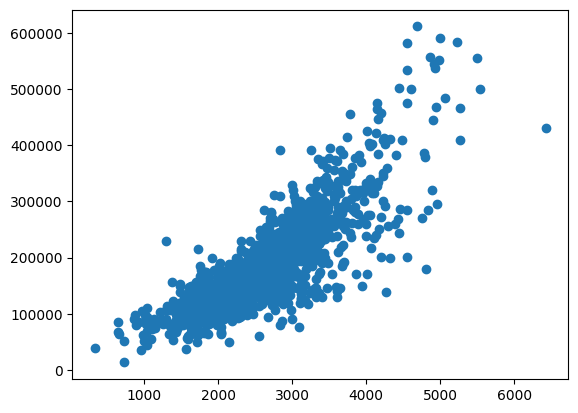

In [53]:
plt.scatter(X['Total SF'],y)
# ax.scatter(df['carat'], df['price'], c=df['color'].map(colors))

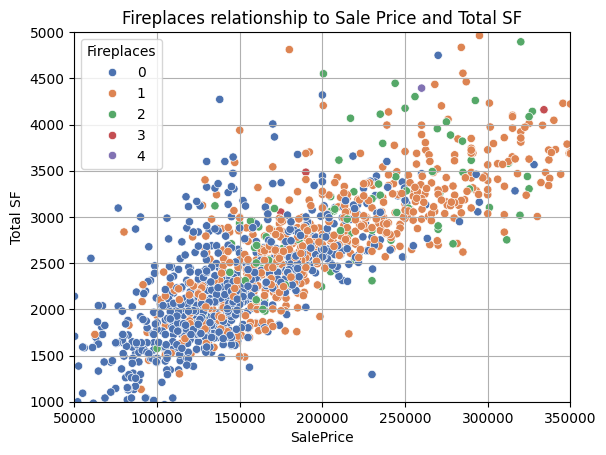

In [54]:
fps=sns.scatterplot(x=y, y=X['Total SF'], data=X, hue='Fireplaces', palette="deep")
fps.set_ylim(1000,5000)
fps.set_xlim(50000,350000)
plt.title("Fireplaces relationship to Sale Price and Total SF")
plt.grid()


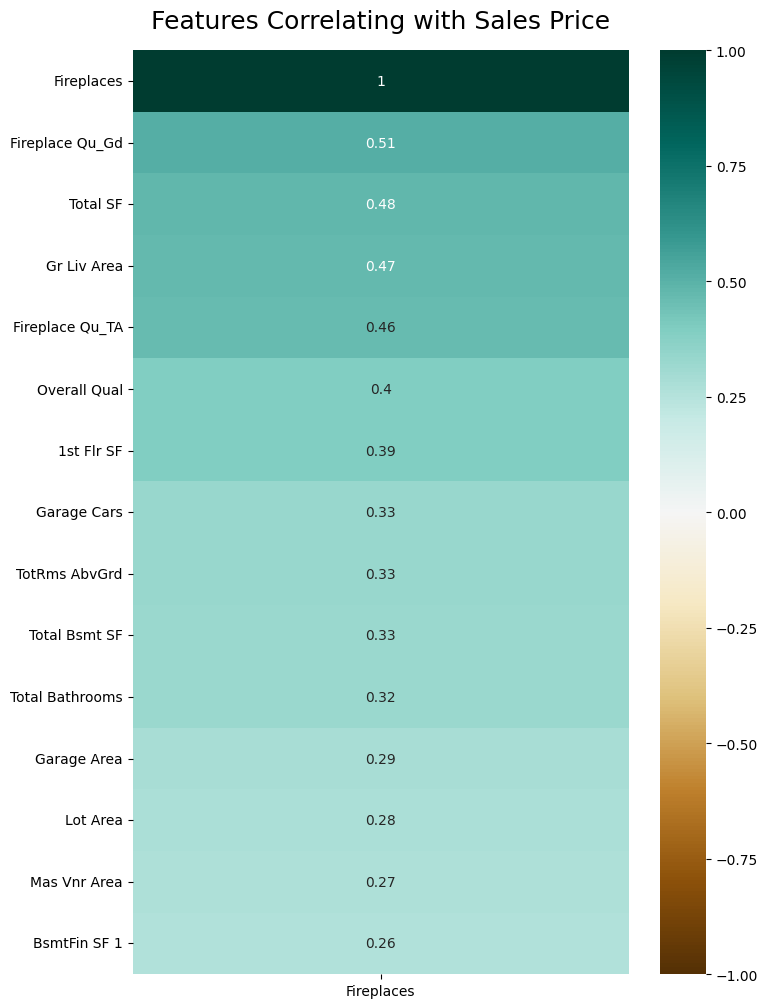

In [55]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(X.corr()[['Fireplaces']].sort_values(by='Fireplaces', ascending=False)[:15], vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Sales Price', fontdict={'fontsize':18}, pad=16);

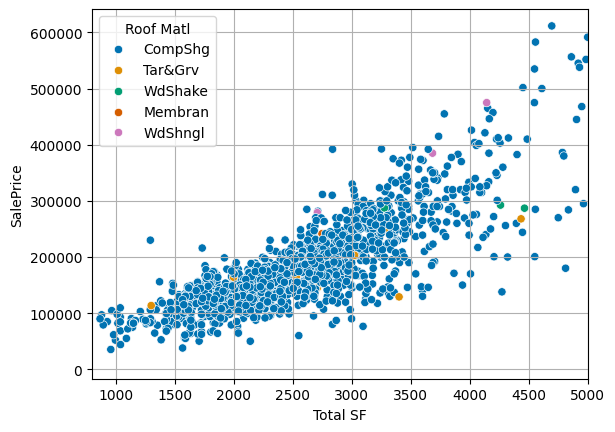

In [56]:
fps=sns.scatterplot(x=X['Total SF'], y=y, data=train, hue='Roof Matl', palette="colorblind")
# plt.scatter(train['Lot Area'], "Mansard", color="yellow")
#import seaborn as sns
#import matplotlib.pyplot as plt
# fps.set_ylim(1000,5000)
fps.set_xlim(800,5000)
plt.grid()


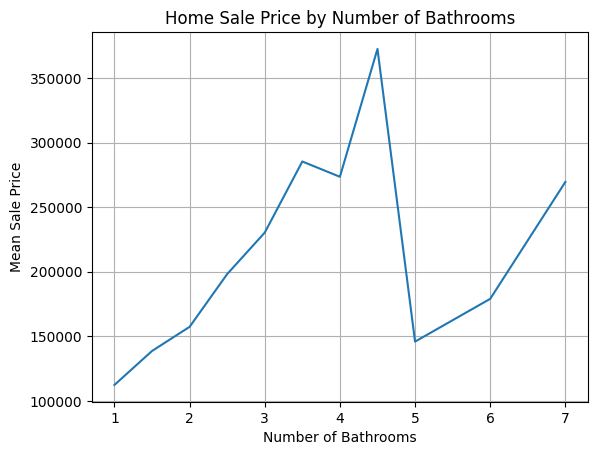

In [57]:
train['Total Bathrooms'] = train['Bsmt Full Bath'] + 0.5*X['Bsmt Half Bath'] + X['Full Bath'] + 0.5*X['Half Bath']
plt.plot(train.groupby("Total Bathrooms")["SalePrice"].mean())
plt.xlabel("Number of Bathrooms")
plt.ylabel("Mean Sale Price")
plt.title("Home Sale Price by Number of Bathrooms")
plt.grid()

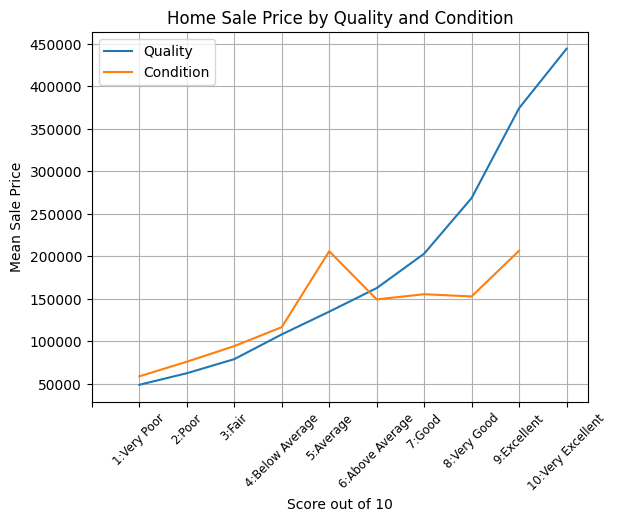

In [58]:
# train['Overall Qual'] = train['Bsmt Full Bath'] + 0.5*X['Bsmt Half Bath'] + X['Full Bath'] + 0.5*X['Half Bath']
plt.plot(train.groupby("Overall Qual")["SalePrice"].mean(), label="Quality")
plt.plot(train.groupby("Overall Cond")["SalePrice"].mean(), label="Condition")
qual=["","1:Very Poor","2:Poor","3:Fair","4:Below Average","5:Average","6:Above Average","7:Good","8:Very Good",
      "9:Excellent","10:Very Excellent"]
plt.xlabel("Score out of 10")
plt.ylabel("Mean Sale Price")
plt.title("Home Sale Price by Quality and Condition")
plt.legend()
plt.grid()
# plt.bar(range(len(qual)), qual, align='center')
plt.xticks(range(len(qual)), qual, size='small')
plt.xticks(rotation=45)

plt.show()

Text(0.5, 1.0, 'Proximity to Amenities or Distractions')

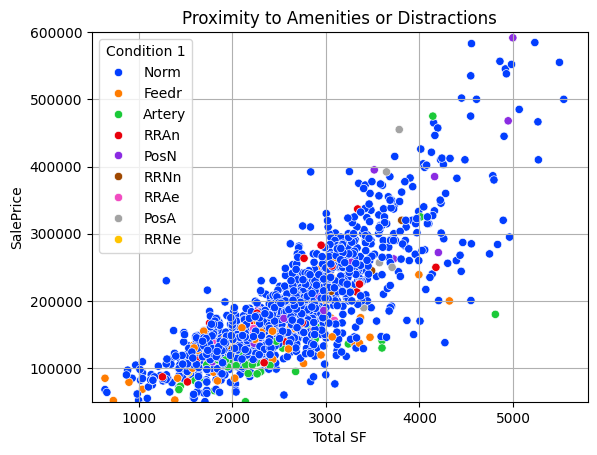

In [59]:
fps=sns.scatterplot(x=X['Total SF'], y=y, data=train, hue='Condition 1', palette="bright")
fps.set_ylim(50000,600000)

fps.set_xlim(500,5800)
plt.grid()
plt.title("Proximity to Amenities or Distractions")

In [60]:
#total bathrooms to mean sales price
X['Total Bathrooms']


0       2.0
1       2.5
2       2.0
3       3.5
4       2.5
       ... 
1533    3.5
1534    2.0
1535    2.5
1536    1.5
1537    3.0
Name: Total Bathrooms, Length: 1536, dtype: float64

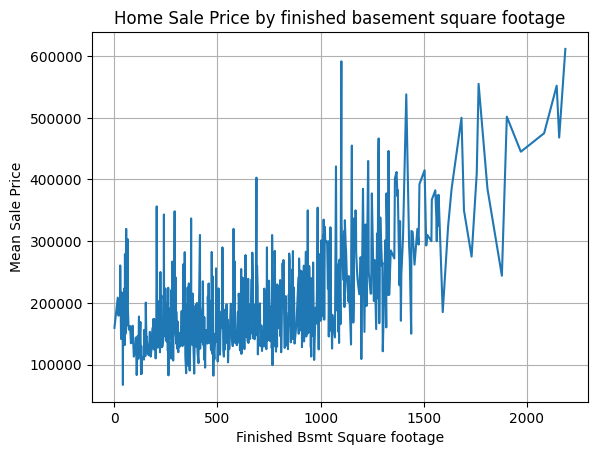

In [61]:
plt.plot(train.groupby("BsmtFin SF 1")["SalePrice"].mean(), label="Quality")
# plt.plot(train.groupby("Bsmt Unf SF")["SalePrice"].mean(), label="Condition")

plt.xlabel("Finished Bsmt Square footage")
plt.ylabel("Mean Sale Price")
plt.title("Home Sale Price by finished basement square footage")
plt.grid()

<ipython-input-62-c8290dd8bb38>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X['BsmtFin SF 1'], y=y, data=train, palette="colorblind")
<ipython-input-62-c8290dd8bb38>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X['Bsmt Unf SF'], y=y, data=train, palette="colorblind")


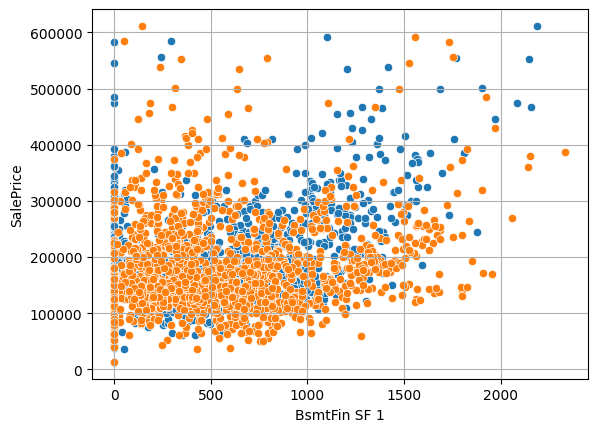

In [62]:
sns.scatterplot(x=X['BsmtFin SF 1'], y=y, data=train, palette="colorblind")
sns.scatterplot(x=X['Bsmt Unf SF'], y=y, data=train, palette="colorblind")

plt.grid()
# this one doesnt really tell the story we want, and we should consider using a metric
#other than square foot for our x values